In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv1D, Flatten, Dropout, Activation, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold

from shutil import copyfile
#copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/bert-tokenization/bert_tokenization.py", dst = "../working/bert_tokenization.py")

import bert_tokenization
#from transformers import BertTokenizer

Import libraries that we need

# Data Overview

In [2]:
df_train = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/train.csv')
df_test = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/test.csv')
df_train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [3]:
df_train.dropna(how='any',axis=0,inplace=True)
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df_test.isnull().sum()

textID       0
text         0
sentiment    0
dtype: int64

In [5]:
df_test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


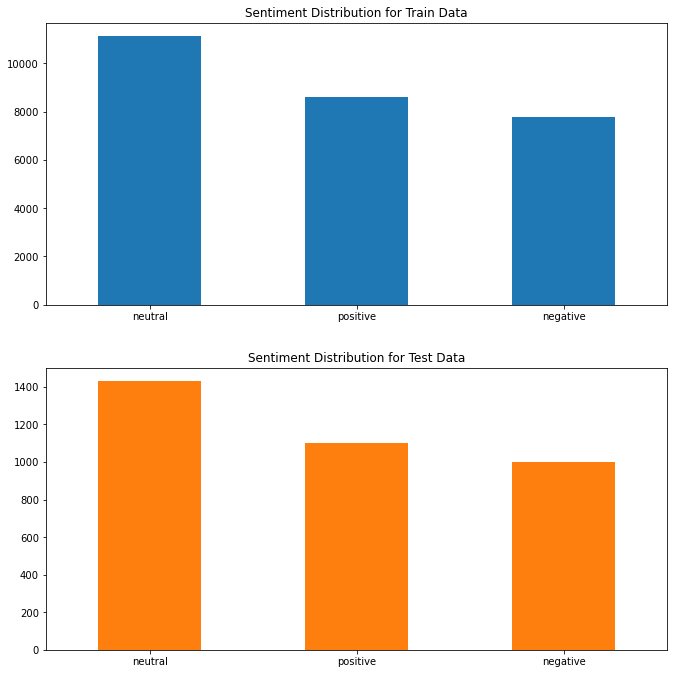

In [6]:
colors = sns.color_palette()
plt.subplot(211)
sentiment_num_1 = df_train['sentiment'].value_counts()
sentiment_num_1.plot(kind='bar',figsize=(10,10),color=colors[0],rot=0)
plt.title('Sentiment Distribution for Train Data')

plt.subplot(212)
sentiment_num_2 = df_test['sentiment'].value_counts()
sentiment_num_2.plot(kind='bar',figsize=(10,10),color=colors[1],rot=0)
plt.title('Sentiment Distribution for Test Data')

plt.tight_layout(pad =3)
plt.show()

Simple visualization for data distribution (The sentiment distributions for train and test data are almost same)

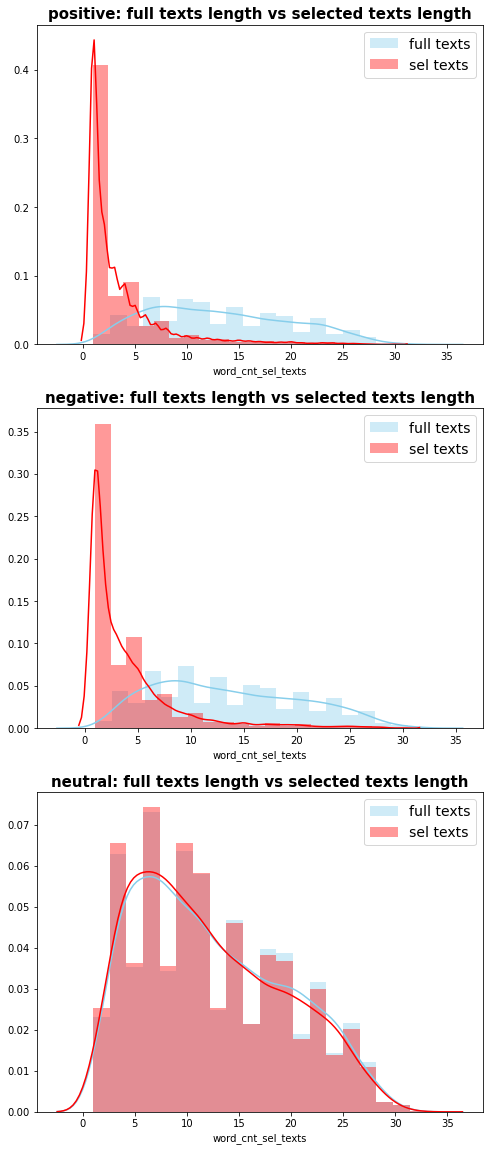

In [7]:
df_train['word_cnt_full_texts'] = df_train['text'].apply(lambda x: len(x.split()))
df_train['word_cnt_sel_texts'] = df_train['selected_text'].apply(lambda x: len(x.split()))
fig,axes = plt.subplots(nrows=3,ncols=1,figsize=(8,20))
for i,s in enumerate(['positive','negative','neutral']):
    sns.distplot(df_train[df_train.sentiment==s]['word_cnt_full_texts'],
                 bins=20, color='skyblue', label='full texts', ax=axes[i])
    sns.distplot(df_train[df_train.sentiment==s]['word_cnt_sel_texts'],
                 bins=20, color='red', label='sel texts', ax=axes[i])
    axes[i].legend(fontsize=14)
    axes[i].set_title('%s: full texts length vs selected texts length'%(s),fontsize=15,fontweight='bold')

It looks like for neutral tweets, slected texts and full texts are almost the same. While for positive and negative tweets, selected texts are only a small part of full texts.

# Bert

First I take a look at how the tokenizer works

In [8]:
bert_layer = hub.KerasLayer('../input/berthub', trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [9]:
print(df_train['text'][1]) 
print(tokenizer.tokenize(df_train['text'][1]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_train['text'][1])))

 Sooo SAD I will miss you here in San Diego!!!
['soo', '##o', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego', '!', '!', '!']
[17111, 2080, 6517, 1045, 2097, 3335, 2017, 2182, 1999, 2624, 5277, 999, 999, 999]


In [10]:
print(df_train['selected_text'][1])
print(tokenizer.tokenize(df_train['selected_text'][1]))
print(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df_train['selected_text'][1])))

Sooo SAD
['soo', '##o', 'sad']
[17111, 2080, 6517]


In [11]:
print(tokenizer.convert_tokens_to_ids(['[CLS]']))
print(tokenizer.convert_tokens_to_ids(['[SEP]']))

[101]
[102]


## Encode train and test data

Then I segment encoding part step by step

Step 1. Decompose full texts into three parts: texts before selected texts, selected texts and texts after selected texts

I use the second sentence as an example

In [12]:
train_texts = df_train['text']
train_sel_texts = df_train['selected_text']
train_sentiment = df_train['sentiment']
texts = list(train_texts)
sentiments = list(train_sentiment)
sel_texts = list(train_sel_texts)
len(sel_texts),len(texts),len(sentiments)

(27480, 27480, 27480)

In [13]:
sentiments[1],texts[1],sel_texts[1]

('negative', ' Sooo SAD I will miss you here in San Diego!!!', 'Sooo SAD')

In [14]:
start_idx = texts[1].find(sel_texts[1])
end_idx = start_idx + len(sel_texts[1])-1                
sentiment = sentiments[1]
full_text_1 = tokenizer.tokenize(texts[1][:start_idx])
full_text_2 = tokenizer.tokenize(texts[1][start_idx:end_idx+1])
full_text_3 = tokenizer.tokenize(texts[1][end_idx+1:])
sentiment,full_text_1,full_text_2,full_text_3

('negative',
 [],
 ['soo', '##o', 'sad'],
 ['i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego', '!', '!', '!'])

Step 2. tokenize three input arrays: input_ids,attention_masks,type_ids

In [15]:
max_len=150

In [16]:
input_tokens = ['[CLS]'] + [sentiment] + ['[SEP]'] + full_text_1+ full_text_2 + full_text_3 +['[SEP]']
pad_len = max_len - len(input_tokens)
valid_input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
input_ids = valid_input_ids + [0]*pad_len
attention_masks = [1]*len(valid_input_ids) + [0]*pad_len
type_ids = [0]*3 + [1]*(len(valid_input_ids)-3)+[0]*pad_len
print(input_tokens)
print(input_ids)
print(attention_masks)
print(type_ids)

['[CLS]', 'negative', '[SEP]', 'soo', '##o', 'sad', 'i', 'will', 'miss', 'you', 'here', 'in', 'san', 'diego', '!', '!', '!', '[SEP]']
[101, 4997, 102, 17111, 2080, 6517, 1045, 2097, 3335, 2017, 2182, 1999, 2624, 5277, 999, 999, 999, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

Step 3. tokenize two output arrays: start and end

In [17]:
start_tokens = [0]*(len(full_text_1)+3)+[1]+[0]*(max_len-len(full_text_1)-4)
end_tokens = [0]*(len(full_text_1)+len(full_text_2)+2)+[1]+[0]*(max_len-len(full_text_1)-len(full_text_2)-3)
print(start_tokens)
print(end_tokens)

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Check if all the arrays have the same length

In [18]:
len(input_ids),len(attention_masks),len(type_ids),len(start_tokens),len(end_tokens)

(150, 150, 150, 150, 150)

## Wrap the step-by-step encoding methods

In [19]:
def bert_encode_train(sentiments, texts, sel_texts, tokenizer, max_len =512):
    all_input_ids = []
    all_masks = []
    all_type_ids = []
    all_start_tokens = []
    all_end_tokens = []
    
    
    for i in range(len(texts)):
        
        start_idx = texts[i].find(sel_texts[i])
        end_idx = start_idx + len(sel_texts[i])-1                
        sentiment = sentiments[i]
        full_text_1 = tokenizer.tokenize(texts[i][:start_idx])
        full_text_2 = tokenizer.tokenize(texts[i][start_idx:end_idx+1])
        full_text_3 = tokenizer.tokenize(texts[i][end_idx+1:])
        
        input_tokens = ['[CLS]'] + [sentiment] + ['[SEP]'] + full_text_1+ full_text_2 + full_text_3 +['[SEP]']
        pad_len = max_len - len(input_tokens)
        valid_input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        input_ids = valid_input_ids + [0]*pad_len
        attention_masks = [1]*len(valid_input_ids) + [0]*pad_len
        #type_ids = [0]*3 + [1]*(len(valid_input_ids)-3) + [0]*pad_len
        type_ids = [0]*len(input_ids)
        
        start_tokens = [0]*(len(full_text_1)+3)+[1]+[0]*(max_len-len(full_text_1)-4)
        end_tokens = [0]*(len(full_text_1)+len(full_text_2)+2)+[1]+[0]*(max_len-len(full_text_1)-len(full_text_2)-3)
        
        all_input_ids.append(input_ids)
        all_masks.append(attention_masks)
        all_type_ids.append(type_ids)
        all_start_tokens.append(start_tokens) 
        all_end_tokens.append(end_tokens)
        
    return np.array(all_input_ids), np.array(all_masks), np.array(all_type_ids),np.array(all_start_tokens),np.array(all_end_tokens)

Check max length after bert encoding

In [20]:
max_len = 0
for i in range(df_train.shape[0]+1):
    try:
        tokens = tokenizer.tokenize(df_train['text'][i])
        input_ids = tokenizer.convert_tokens_to_ids(['[CLS]']+list(df_train.loc[i,'sentiment'])+
                                       ['[SEP]']+tokens+['[SEP]'])
        max_len = max(max_len, len(input_ids))
    except:
        pass

print('Max length for training data: ', max_len)

Max length for training data:  118


In [21]:
max_len = 0
for i in range(df_train.shape[0]+1):
    try:
        tokens = tokenizer.tokenize(df_test['text'][i])
        input_ids = tokenizer.convert_tokens_to_ids(['[CLS]']+list(df_test.loc[i,'sentiment'])+
                                       ['[SEP]']+tokens+['[SEP]'])
        max_len = max(max_len, len(input_ids))
    except:
        pass

print('Max length for test data: ', max_len)

Max length for test data:  79


Since the word count of full texts and selected texts for neutral text is almost the same, I only use positive and negative texts as training and test data. 

In [22]:
train_texts = df_train[df_train['sentiment']!='neutral']['text']
train_sel_texts = df_train[df_train['sentiment']!='neutral']['selected_text']
train_sentiment = df_train[df_train['sentiment']!='neutral']['sentiment']
#train_texts = df_train['text']
#train_sel_texts = df_train['selected_text']
#train_sentiment = df_train['sentiment']
full_texts = list(train_texts)
sentiments = list(train_sentiment)
sel_texts = list(train_sel_texts)

train_input = bert_encode_train(sentiments,full_texts,sel_texts,tokenizer, max_len =150)[:3]
train_labels = bert_encode_train(sentiments,full_texts,sel_texts,tokenizer, max_len =150)[3:]

In [23]:
def bert_encode_test(sentiments, texts, tokenizer, max_len =512):
    all_input_ids = []
    all_masks = []
    all_type_ids = []

    for i in range(len(texts)):
        text = tokenizer.tokenize(texts[i])               
        sentiment = sentiments[i]
        input_tokens = ['[CLS]'] + [sentiment] + ['[SEP]'] + text +['[SEP]']
        pad_len = max_len - len(input_tokens)
        valid_input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        input_ids = valid_input_ids + [0]*pad_len
        attention_masks = [1]*len(valid_input_ids) + [0]*pad_len
        #type_ids = [0]*3 + [1]*(len(valid_input_ids)-3) + [0]*pad_len
        type_ids = [0]*len(input_ids)
        
        all_input_ids.append(input_ids)
        all_masks.append(attention_masks)
        all_type_ids.append(type_ids)
      
    return np.array(all_input_ids), np.array(all_masks), np.array(all_type_ids)

In [24]:
test_texts = df_test[df_test['sentiment']!='neutral']['text']
test_sentiment = df_test[df_test['sentiment']!='neutral']['sentiment']
#test_texts = df_test['text']
#test_sentiment = df_test['sentiment']
full_texts_test = list(test_texts)
sentiments_test = list(test_sentiment)

test_input = bert_encode_test(sentiments_test, full_texts_test, tokenizer, max_len =150)

## Build Bert Model with CNN head

In [25]:
def build_bert(bert_layer, max_len =512):
    adam = Adam(lr=1e-3)
    main_input = Input(shape =(max_len,), dtype =tf.int32)
    input_word_ids = Input(shape = (max_len,),dtype =tf.int32)
    input_mask = Input(shape = (max_len,),dtype =tf.int32)
    input_type_ids = Input(shape = (max_len,),dtype =tf.int32)
    
    clf_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    #pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])
    #clf_output = sequence_output[1]
    
    out1 = Dropout(0.1)(clf_output[1])
    out1 = Conv1D(filters=1, kernel_size=1) (out1)
    out1 = Flatten()(out1)
    out1 = Activation('softmax')(out1)
    
    out2 = Dropout(0.1)(clf_output[1])
    out2 = Conv1D(filters=1, kernel_size=1) (out2)
    out2 = Flatten()(out2)
    out2 = Activation('softmax')(out2)
    
    model = Model(inputs = [input_word_ids, input_mask, input_type_ids], outputs =[out1,out2])
    model.compile(optimizer=Adam(lr=3e-5) ,loss = 'categorical_crossentropy')
    #print(model.summary())
    return model


model = build_bert(bert_layer,max_len=150)
filepath='best_weight.hdf5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
model.fit(train_input, train_labels, epochs =3, batch_size = 16, callbacks=[checkpoint], validation_split=0.2)
#for layer in model.layers:
    #print(layer.output_shape)

Epoch 1/3
819/819 [==============================] - ETA: 0s - loss: 2.8048 - activation_loss: 1.4018 - activation_1_loss: 1.4030
Epoch 00001: val_loss improved from inf to 2.44348, saving model to best_weight.hdf5
819/819 [==============================] - 284s 347ms/step - loss: 2.8048 - activation_loss: 1.4018 - activation_1_loss: 1.4030 - val_loss: 2.4435 - val_activation_loss: 1.2122 - val_activation_1_loss: 1.2313
Epoch 2/3
819/819 [==============================] - ETA: 0s - loss: 1.8647 - activation_loss: 0.9506 - activation_1_loss: 0.9141
Epoch 00002: val_loss did not improve from 2.44348
819/819 [==============================] - 279s 341ms/step - loss: 1.8647 - activation_loss: 0.9506 - activation_1_loss: 0.9141 - val_loss: 2.5862 - val_activation_loss: 1.2978 - val_activation_1_loss: 1.2885
Epoch 3/3
819/819 [==============================] - ETA: 0s - loss: 0.9427 - activation_loss: 0.5042 - activation_1_loss: 0.4385
Epoch 00003: val_loss did not improve from 2.44348
819/8

In [26]:
def jaccard_similarity(str1,str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    if not a and not b:
        return 0.5 
    c = a.intersection(b)
    return float(len(c)/(len(a)+len(b)-len(c)))

In [27]:
jaccard_similarity(' Sooo SAD I will miss you here in San Diego!!!','Sooo SAD')

0.2

# Predict and Submission

When it comes to the submission, selected texts of neutral texts are assigned with full texts.

In [28]:
best_model = load_model('./best_weight.hdf5',custom_objects={'KerasLayer':bert_layer})
pred_start,pred_end = model.predict(test_input)
results = []
for k in range(test_input[0].shape[0]):
    a = np.argmax(pred_start[k])
    b = np.argmax(pred_end[k])
    
    if a>b:
        sel_text = full_texts_test[k]
    else:
        sel_text = ' '.join(tokenizer.convert_ids_to_tokens(test_input[0][k,a:b+1]))
        
    results.append(sel_text)

#google fulltokenizer will generate meaingless punction ##   
results = [x.replace(' ##','') for x in results]
    
for k in range(df_test.shape[0]):
    if df_test.loc[k, 'sentiment'] == 'neutral':
        df_test.loc[k, 'selected_text'] = df_test.loc[k, 'text']

df_test.loc[df_test['sentiment']!='neutral','selected_text'] = results
#df_test['selected_text'] = results
output = pd.read_csv('/kaggle/input/tweet-sentiment-extraction/sample_submission.csv')
output['selected_text'] = df_test['selected_text']
output.head(10)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,exciting ( precisely - - skyscrapers galore ) ...
2,eee518ae67,", such a shame"
3,01082688c6,happy bday !
4,33987a8ee5,like
5,726e501993,that ` s great !
6,261932614e,hates
7,afa11da83f,completely blocked
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...


In [29]:
output.to_csv('submission.csv',index=False,header=True)